<a href="https://colab.research.google.com/github/sanAkel/ufs_diurnal_diagnostics/blob/main/RTOFS/binary_nc_converter/read_archive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cartopy

In [2]:
import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

data_path="/content/drive/MyDrive/datasets/tmp/read_archive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls -al $data_path

total 2609258
-rw------- 1 root root   59375616 Aug 31  2018 depth_GLBb0.08_09m11.a
-rw------- 1 root root        418 Aug 31  2018 depth_GLBb0.08_09m11.b
-rw------- 1 root root  178124504 Aug 31  2018 depth_GLBb0.08_09m11.nc
-rw------- 1 root root  296852976 Aug 31  2018 read_grid.nc
-rw------- 1 root root 1128136704 Aug 31  2018 regional.grid.a
-rw------- 1 root root       1065 Aug 31  2018 regional.grid.b
-rw------- 1 root root 1009385472 Apr 15 20:32 v2.4_rtofs_glo.t00z.n00.archs.a
-rw------- 1 root root       1882 Apr 15 20:33 v2.4_rtofs_glo.t00z.n00.archs.b


### These functions are based on those at [pyhycom.](https://github.com/uwincm/pyhycom/blob/master/pyhycom.py)

In [5]:
# return file handle
def open_a_file(filename, mode):
    file = open(filename[:-1]+'a',mode=mode)
    return file

#Return the name of the corresponding HYCOM "b" file.
def get_b_filename(fName):
    bfilename = fName[:-1]+'b'
    return bfilename

#Return a list where each element contains text from each line of `b file`
def getTextFile(fName):
    return [line.rstrip() for line in open(fName,'r').readlines()]

In [6]:
# get dimensions of an archive from .b file
def getDims(fName, topo_file=False):

  f = getTextFile(get_b_filename(fName))
  idmFound, jdmFound = [False, False]

  if topo_file:
    for line in f:
        if 'i/jdm' in line:
          xx = line.split()[3]; jdm = xx[0:4]
          idm = line.split()[2]
          idmFound = True
          jdmFound = True
        if idmFound and jdmFound:break
  else:
    for line in f:
        if 'idm' in line:
          idm = line.split()[0]
          idmFound = True
        if 'jdm' in line:
          jdm = line.split()[0]
          jdmFound = True
        if idmFound and jdmFound:break

  return int(jdm), int(idm)

In [7]:
def getFieldIndex(field, fName):
    f = getTextFile(get_b_filename(fName))
    if 'arch' in fName.split('/')[-1]:f = f[10:] # skip first 10 lines
    if 'grid' in fName.split('/')[-1]:f = f[3:] # skip first 3 lines
    fieldIndex = []
    for line in f:
      if field == line.split()[0].replace('.','').replace(':',''):
        fieldIndex.append(f.index(line))
    return fieldIndex

In [8]:
def getField(field, fName, undef=np.nan, x_range=None, y_range=None):

  dims = getDims(fName)
  if dims.__len__() == 2:
    jdm, idm = dims
  else:
    jdm, idm, kdm = dims
    print("\n-- CAUTION! Read 3d archive is not yet ready!\n")

  reclen = 4*idm*jdm # Record length in bytes
  # HYCOM binary data is written out in chunks/"words" of multiples of 4096*4 bytes.
  # Length of one level of one variable (reclen) will be between
  # consecutive multiples of the wordlen. Data is padded to bring the volume
  # up to the next multiple. The "pad" value below is equal to the bytes that are needed to do this.
  wordlen = 4096*4
  pad = wordlen * np.ceil(reclen / wordlen) - reclen   # Pad size in bytes
  fieldRecords = getFieldIndex(field,fName)         # Get field record indices
  fieldAddresses = np.array(fieldRecords)*(reclen+pad) # Address in bytes

  file = open_a_file(fName,mode='rb') # Open file
  if dims.__len__() == 2: # 2-d field
    field = np.zeros((jdm,idm))
    file.seek(int(fieldAddresses[0]),0) # Move to address of the field
    data = file.read(idm*jdm*4)
    field = np.reshape(np.frombuffer(data, dtype='float32', count=idm*jdm),(jdm,idm)).byteswap()

    if not x_range is None:
      field = field[:,:,x_range]
    if not y_range is None:
      field = field[:,y_range,:]

  #field = field.byteswap() # Convert to little-endian
  file.close()
  field[field == np.float32(2**100)] = undef

  return field

In [9]:
# Number of records in the binary file, read from .b
def getNumberOfRecords(fName):
  f = getTextFile(get_b_filename(fName))
  if 'arch' in fName:
      f = f[10:]; return len(f)
  if 'grid' in fName:
      f = f[3:]; return len(f)
  if 'depth' in fName:
      return 1
  if 'restart' in fName:
      f = f[2:]; return len(f)

In [10]:
def getBathymetry(grid_fName, topog_fName, undef=np.nan):

  jdm,idm = getDims(grid_fName)

  file = open_a_file(topog_fName, mode='rb')
  #Data is in float32, which has 4 bytes/value
  data = file.read(idm*jdm*4)
  field = np.reshape(np.frombuffer(data,dtype='float32',count=idm*jdm).byteswap(),(jdm,idm))
  file.close()

  print(f"field.shape={field.shape}")
  field[field>2**99] = undef

  return field

In [11]:
bFile=get_b_filename(data_path+"/regional.grid.a")
print(f"Reading {bFile}\n")

jm, im = getDims(data_path+"/regional.grid.a")
print(f"im={im}, jm={jm}")

jm, im = getDims(data_path+"/depth_GLBb0.08_09m11.a", topo_file=True)
print(f"im={im}, jm={jm}")

Reading /content/drive/MyDrive/datasets/tmp/read_archive//regional.grid.b

im=4500, jm=3298
im=4500, jm=3298


In [12]:
fn1 = data_path+"/regional.grid.a"
print(getFieldIndex('plat',fn1))
print("\n")

fn2 = data_path+"/v2.4_rtofs_glo.t00z.n00.archs.a"
print(getFieldIndex('srfhgt',fn2))
print(getFieldIndex('salin',fn2))

[1]


[1]
[16]


In [13]:
print(getNumberOfRecords(data_path+"/regional.grid.a"))
print("\n")
print(getNumberOfRecords(data_path+"/depth_GLBb0.08_09m11.a"))
print("\n")
print(getNumberOfRecords(data_path+"/v2.4_rtofs_glo.t00z.n00.archs.a"))

12


0


17


In [14]:
depth=getBathymetry(data_path+"/regional.grid.a", data_path+"/depth_GLBb0.08_09m11.a")

field.shape=(3298, 4500)


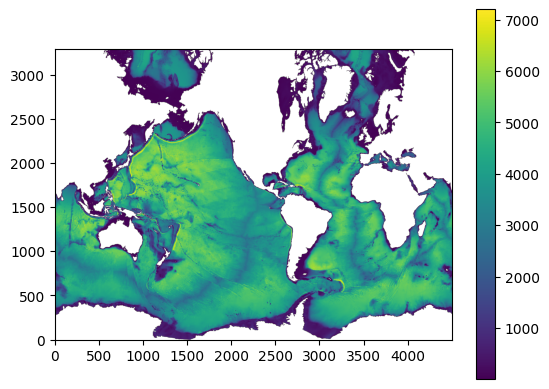

In [15]:
plt.imshow(depth, origin='lower')
plt.colorbar()

In [16]:
plon = getField('plon', data_path+"/regional.grid.a")
plat = getField('plat', data_path+"/regional.grid.a")

# variables
sst = getField('temp',   data_path+"/v2.4_rtofs_glo.t00z.n00.archs.a")
sss = getField('salin',  data_path+"/v2.4_rtofs_glo.t00z.n00.archs.a")
ssh = getField('srfhgt', data_path+"/v2.4_rtofs_glo.t00z.n00.archs.a")

uvel = getField('u-vel', data_path+"/v2.4_rtofs_glo.t00z.n00.archs.a")
vvel = getField('v-vel', data_path+"/v2.4_rtofs_glo.t00z.n00.archs.a")

In [17]:
# SSH in m
grav = 9.81
ssh = ssh/grav #https://github.com/HYCOM/HYCOM-src/blob/5c9f48918374965e2df09042180ea8a69c650dc4/mod_cb_arrays.F90#L90

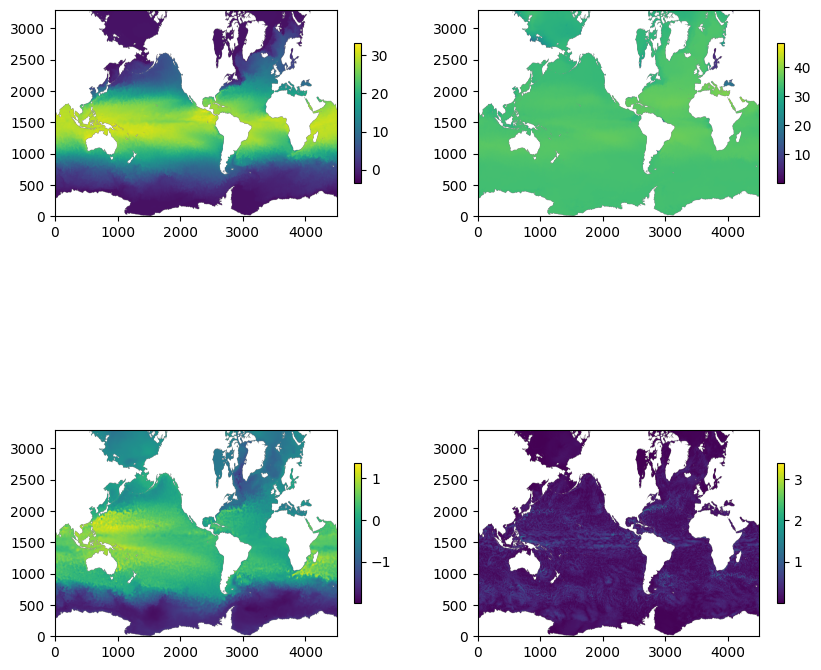

In [18]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(sst, origin='lower'); plt.colorbar(shrink=0.4)

plt.subplot(2,2,2)
plt.imshow(sss, origin='lower'); plt.colorbar(shrink=0.4)

plt.subplot(2,2,3)
plt.imshow(ssh, origin='lower'); plt.colorbar(shrink=0.4)

plt.subplot(2,2,4)
plt.imshow( np.sqrt(uvel**2 + vvel**2), origin='lower'); plt.colorbar(shrink=0.4)

In [19]:
!cat $data_path/v2.4_rtofs_glo.t00z.n00.archs.b

0.281c NAVGEM wind, thermal, precip 3-hrly forcing ; LWcorr; GDEM42 SSS relax;  
17T Sigma2*; GDEM4 Jan init; KPP; SeaWiFS KPAR; HYCOM+CICE; A=20;Smag=.05;      
Z(7):1-7,Z(16):8,Z(2):10-16,Z(13):dp00/f/x=36/1.18/262;Z(3):400-600m; NOGAPSsnow
sigma:84-14m; depth_GLBb0.08_11; apply offlux to CICE; 2.2.99DHi-900            
   22    'iversn' = hycom version number x10
  930    'iexpt ' = experiment number x10
    3    'yrflag' = days in year flag
 4500    'idm   ' = longitudinal array size
 3298    'jdm   ' = latitudinal  array size
field       time step  model day  k  dens        min              max
montg1   =   49012560  45382.000  6 34.000  -5.4217045E+01   1.8597734E+01
srfhgt   =   49012560  45382.000  0  0.000  -1.9522026E+01   1.3333766E+01
steric   =   49012560  45382.000  0  0.000  -1.9625463E+01   2.4832483E+01
surflx   =   49012560  45382.000  0  0.000  -9.9825427E+02   1.0107173E+03
salflx   =   49012560  45382.000  0  0.000  -9.1576463E-01   9.0152234E-02
bl_dpth  =   49012

## Create (xarray) dataset to simply life!

In [20]:
# convert time stamp in archive to yyyy/mm/dd:hh:mm:ss
# translation of https://github.com/HYCOM/HYCOM-tools/blob/master/bin/hycom_wind_ymdh.f

def hycom_wind_ymdh(dtime, yrflag=3):

  if yrflag !=3:
    raise ValueError("yrflag must be 3")

  [iyear, month, iday, ihour] = fordate(dtime, yrflag)

  return iyear, month, iday, ihour

def fordate(dtime, yrflag=3):

  if yrflag !=3:
    raise ValueError("yrflag must be 3")

  month0=np.asarray([[1,  31,  61,  91, 121, 151, 181, 211, 241, 271, 301, 331, 361],
               [1,  32,  60,  91, 121, 152, 182, 213, 244, 274, 305, 335, 366],
               [1,  32,  61,  92, 122, 153, 183, 214, 245, 275, 306, 336, 367]])

  [iyear, jday, ihour] = forday(dtime, yrflag)

  if (np.mod(iyear,4) == 0):
    k = 3  #leap year
  else:
    k = 2  #standard year

  for m in range(0, 12):
    #print(jday, month0[k-1, m], month0[k-1, m+1])
    if ((jday >= month0[k-1, m]) and (jday < month0[k-1, m+1])):
      month = m+1
      iday  = jday - month0[k-1, m] + 1
  #print(month, iday)

  return iyear, month, iday, ihour

def forday(dtime, yrflag=3): # yrflag is always set to 3.
  """
  # Follow @awallcraft's logic to undo hycom_wind_date conversion
  # https://github.com/HYCOM/HYCOM-tools/blob/3647ab0efbce59bcb2d8d6b3f66978b4a661b6b6/bin/hycom_wind_date.f#L54
  """

  if yrflag !=3:
    raise ValueError("yrflag must be 3")

  # model day is calendar days since 01/01/1901
  iyr   = (dtime-1.)/365.25
  nleap = iyr/4.
  dtim1 = 365.0*iyr + nleap + 1.
  day   = dtime - dtim1 + 1.
  #print(iyr, nleap, dtim1, day)

  if dtim1 > dtime:
    iyr = iyr - 1
  elif day >= 367.:
    iyr = iyr + 1
  elif ((day >= 366.0) and (np.mod(iyr,4) != 3)):
    iyr = iyr + 1

  nleap = iyr/4
  dtim1 = 365.0*iyr + nleap + 1.
  #print(iyr, nleap, dtim1)

  iyear =  1901 + iyr
  iday  =  dtime - dtim1 + 1
  ihour = (dtime - dtim1 + 1.001 - iday)*24.
  #print(iyear, iday, ihour)

  return iyear, iday, ihour

In [24]:
dummy_date = '2099-01-01'

#print(hycom_wind_ymdh(45370.000)) # 2025/03/20
#print(hycom_wind_ymdh(45382.000)) # 2025/04/01

In [25]:
ds = xr.Dataset()

ds['Latitude'] = xr.DataArray(plat,
    dims=("Y", "X"),
    coords={"Y": np.arange(1, plat.shape[0]+1), "X": np.arange(1, plat.shape[1]+1)},
    name="Latitude",
    attrs={"units": "degrees_north", "long_name": "latitude"})

ds['Longitude'] = xr.DataArray(plon,
    dims=("Y", "X"),
    coords={"Y": np.arange(1, plon.shape[0]+1), "X": np.arange(1, plon.shape[1]+1)},
    name="Longitude",
    attrs={"units": "degrees_east", "long_name": "longitude", "modulo": "360 degrees"})

ds['time'] = np.array([str(dummy_date)], dtype='datetime64')

ds['srfhgt'] = xr.DataArray(ssh,
    dims=("Y", "X"),
    coords={"Y": np.arange(1, ssh.shape[0]+1), "X": np.arange(1, ssh.shape[1]+1)},
    name="srfhgt",
    attrs={"units": "m", "long_name": "surface height"})

ds.attrs = {"source": "NCEP RTOFS v2.5",
            "history": "converted archive to netcdf",
            "using": "https://github.com/NOAA-EMC/RTOFS_GLO"}

ds=ds.set_coords(["Latitude", "Longitude", "time"])

In [26]:
ds

<xarray.Dataset> Size: 178MB
Dimensions:    (Y: 3298, X: 4500, time: 1)
Coordinates:
  * Y          (Y) int64 26kB 1 2 3 4 5 6 7 ... 3293 3294 3295 3296 3297 3298
  * X          (X) int64 36kB 1 2 3 4 5 6 7 ... 4495 4496 4497 4498 4499 4500
    Latitude   (Y, X) float32 59MB -78.64 -78.64 -78.64 ... 47.15 47.1 47.04
    Longitude  (Y, X) float32 59MB 74.16 74.24 74.32 74.4 ... 74.12 74.12 74.12
  * time       (time) datetime64[s] 8B 2099-01-01
Data variables:
    srfhgt     (Y, X) float32 59MB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    source:   NCEP RTOFS v2.5
    history:  converted archive to netcdf
    using:    https://github.com/NOAA-EMC/RTOFS_GLO

## Plot few regions/projections:
- N Pole (Arctic).
- Globe.
- S Pole (Antarctic).

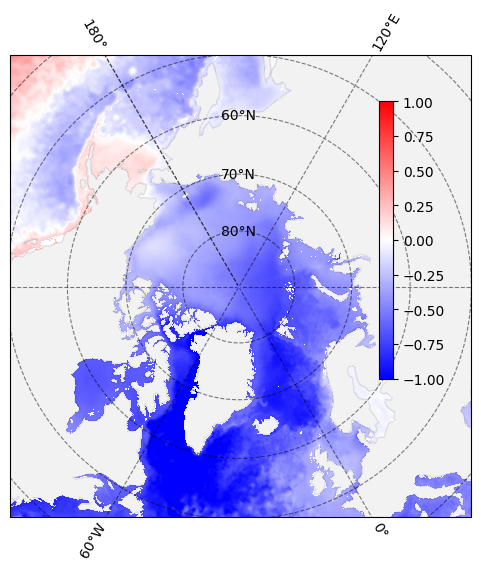

In [40]:
fig = plt.figure(figsize=[8,6])

ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude=-30.0))
ax.add_feature(cfeature.LAND, facecolor='grey', alpha=0.1)
ax.coastlines(color='k', alpha=0.1)
ax.set_extent([-300, 60, 50, 90], ccrs.PlateCarree())

im = ds.srfhgt.plot(ax=ax, x='Longitude', y='Latitude',
            vmin=-1, vmax=1, cmap='bwr',
            transform=ccrs.PlateCarree(),
            add_labels=False, add_colorbar=False)

im.axes.gridlines(color='black', alpha=0.5, linestyle='--', draw_labels=True)

cax = ax.inset_axes([0.8, 0.3, 0.03, 0.6])
fig.colorbar(im, cax=cax, orientation='vertical', ticks=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.])
cax.tick_params(labelsize=10, rotation=0)
cax.set_title('{} [{}]'.format(ds.srfhgt.attrs['long_name'], ds.srfhgt.attrs['units']))
#cax.set_title('{}/{}/{}'.format(ds.time.dt.year.values[0], ds.time.dt.month.values[0], ds.time.dt.day.values[0]))

Text(0.5, 1.0, 'surface height [m]')

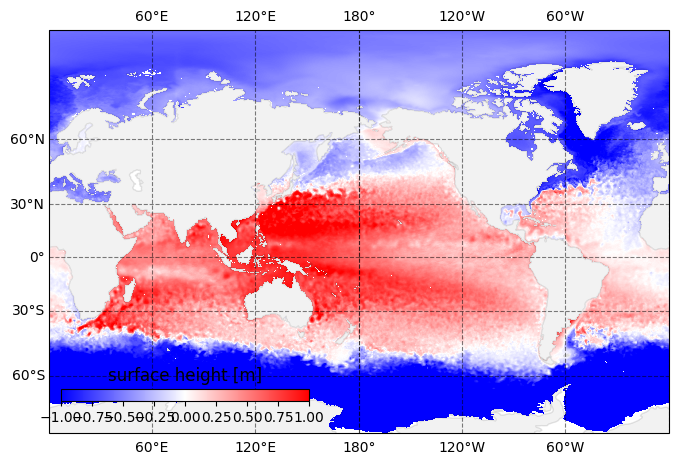

In [55]:
fig = plt.figure(figsize=[8,6])

ax = fig.add_subplot(1,1,1, projection=ccrs.Miller(central_longitude=-180.0))
ax.add_feature(cfeature.LAND, facecolor='grey', alpha=0.1)
ax.coastlines(color='k', alpha=0.1)
#ax.set_extent([-300, 60, -60, 60], ccrs.PlateCarree())

im = ds.srfhgt.plot(ax=ax, x='Longitude', y='Latitude',
            vmin=-1, vmax=1, cmap='bwr',
            transform=ccrs.PlateCarree(),
            add_labels=False, add_colorbar=False)

im.axes.gridlines(color='black', alpha=0.5, linestyle='--', draw_labels=True)

cax = ax.inset_axes([0.02, 0.05, 0.4, 0.03])
fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.])
cax.tick_params(labelsize=8, rotation=0)
cax.set_title('{} [{}]'.format(ds.srfhgt.attrs['long_name'], ds.srfhgt.attrs['units']))
#cax.set_title('{}/{}/{}'.format(ds.time.dt.year.values[0], ds.time.dt.month.values[0], ds.time.dt.day.values[0]))

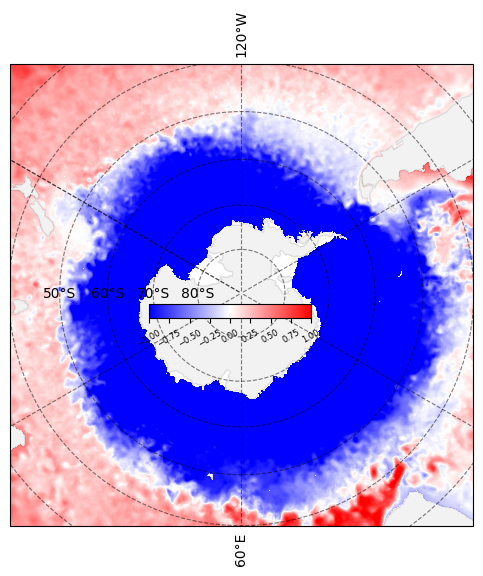

In [41]:
fig = plt.figure(figsize=[8,6])

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=-120.0))
ax.add_feature(cfeature.LAND, facecolor='grey', alpha=0.1)
ax.coastlines(color='k', alpha=0.1)
ax.set_extent([-300, 60, -40, -90], ccrs.PlateCarree())

im = ds.srfhgt.plot(ax=ax, x='Longitude', y='Latitude',
                  vmin=-1, vmax=1, cmap='bwr',
                  transform=ccrs.PlateCarree(),
                 add_labels=False, add_colorbar=False)

im.axes.gridlines(color='black', alpha=0.5, linestyle='--', draw_labels=True)

cax = ax.inset_axes([0.3, 0.45, 0.35, 0.03])
fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.])
cax.tick_params(labelsize=6, rotation=30)
cax.set_title('{} [{}]'.format(ds.srfhgt.attrs['long_name'], ds.srfhgt.attrs['units']))
##cax.set_title('{}/{}/{}'.format(ds.time.dt.year.values[0], ds.time.dt.month.values[0], ds.time.dt.day.values[0]))